# Lesson 03: 
### Dylan Temples 
June 25, 2020

The goal of this lesson is to 

## Learning Objectives
Physics Topics:
- LXe-TPC energy calibration: Doke Plot

Programming Topics:
- Classes
- 2-dimensional fitting

In LXe-TPCs, we observed only S1 light and S2 light, and from these quantities, we calculate other values including the reconstructed energy of the recoil. The objective of this lesson is to illustrate how the gain factors $g_1$ and $g_2$ are calculated and applied to the data to get a reconstructed energy scale. 

Recall that when radiation passes through xenon, it produces some number of scintillation photons, $n_\gamma$, and free electrons, $n_\e$. The average amount of energy it takes for a xenon atom to produce a single quantum is $W=13.7$ eV. Thus, if a particle strikes a xenon atom and induces a recoil of energy $E$, the number of quanta produced is related to the energy by:
$$ E = W (n_\gamma + n_E) $$

There are further complications, because we only detect a number of S1 photons and a number of S2 photons. Firstly, not every scintillation photon that is produced gets detected, which motivates the introduction of the gain factor $g_1$ -- "the number of photons detected per photon emitted". The factor $g_1$ is less than or equal to 1.0, by construction. The gain factor maps $n_\gamma$ to $S1$:
$$ n_\gamma = S1 / g_1 $$

For the electron signal, we detect the secondary scintillation photons the electrons produce as they traverse the gas phase in the detector. We need a factor that takes us from number of electrons produced to number of photons detected:
$$ n_e = S2 / g_2 $$
Here, the factor $g_2$ is the "number of photons detected per electron emitted", and takes into account things like extraction efficiency of the electrons, average number of electroluminesence photons per electron, and light collection efficiency in the gas phase. It does not account for the attenuation of electrons as they drift through the LXe, thus you must correct for this effect before performing a Doke analysis.

Combining this results in the reconstructed energy equation:
$$ E = W \left( \frac{S1}{g_1} + \frac{S2}{g_2} \right) $$
This excercise will take you through calculating the gains $g_1$ and $g_2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class data_class:
    n_entries  = 0      ## Number of data points in file
    e_lifetime = 0.0    ## Electron lifetime during this data acquisition
    
    def __init__(self, f_name, elife):
        data = np.loadtxt(f_name, delimiter=",")
        
        self.e_lifetime = elife
        self.n_entries  = len(data[:,0])
        
        self.Evt_IDs    = data[:,0]  # first column
        self.S1_vals    = data[:,1]  # second column
        self.S2_vals    = data[:,2]  # third column
        self.TS2_vals   = data[:,3]  # fourth column
        self.DT_vals    = data[:,4]  # fifth column
        self.R2_vals    = data[:,5]  # sixth column
        
        self.S2c_vals   = self.S2_vals  * np.exp(self.DT_vals / self.e_lifetime)
        self.TS2c_vals  = self.TS2_vals * np.exp(self.DT_vals / self.e_lifetime)

In [3]:
# Define the file name and read the file into our class
filename = "rawdaq_1901021108_parsed.dat"
filedata = data_class(filename, 10.705056972876482)    

In [4]:
# Define the drift time cuts
dt_cut_lims    = np.array([2.5, 7.5])
dt_cut_indexer = (filedata.DT_vals >= dt_cut_lims[0]) * (filedata.DT_vals <= dt_cut_lims[1])

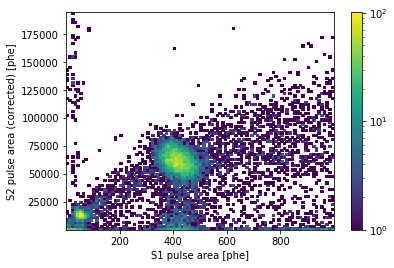

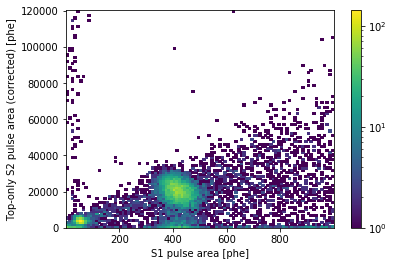

In [5]:
from matplotlib.colors import LogNorm
n_s1s2_bins = 100

# -- Create a 2D histogram of S1 size vs S2 size
plt.figure(3)
h, xedges, yedges, img = plt.hist2d(filedata.S1_vals[dt_cut_indexer],filedata.S2c_vals[dt_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("S2 pulse area (corrected) [phe]")
plt.colorbar()

# -- Create a 2D histogram of S1 size vs Top-S2 size
plt.figure(4)
h, xedges, yedges, img = plt.hist2d(filedata.S1_vals[dt_cut_indexer],filedata.TS2c_vals[dt_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area (corrected) [phe]")
plt.colorbar()

In [6]:
## Define selection cuts and energy for K shell
Kshell_energy          = 33.2 ## keV
Kshell_s1_cut_lims     = np.array([325.0 , 525.0 ])
Kshell_ts2_cut_lims    = np.array([11.0e3 , 35.0e3])
Kshell_s1_cut_indexer  = (filedata.S1_vals   >= Kshell_s1_cut_lims[0] ) * (filedata.S1_vals   <= Kshell_s1_cut_lims[1] )
Kshell_ts2_cut_indexer = (filedata.TS2c_vals >= Kshell_ts2_cut_lims[0]) * (filedata.TS2c_vals <= Kshell_ts2_cut_lims[1])
Kshell_cut_indexer     = Kshell_s1_cut_indexer * Kshell_ts2_cut_indexer * dt_cut_indexer

## Define selection cuts and energy for L shell
Lshell_energy          = 5.2 ## keV
Lshell_s1_cut_lims     = np.array([35.0 , 70.0 ])
Lshell_ts2_cut_lims    = np.array([2.5e3 , 7.0e3])
Lshell_s1_cut_indexer  = (filedata.S1_vals   >= Lshell_s1_cut_lims[0] ) * (filedata.S1_vals   <= Lshell_s1_cut_lims[1] )
Lshell_ts2_cut_indexer = (filedata.TS2c_vals >= Lshell_ts2_cut_lims[0]) * (filedata.TS2c_vals <= Lshell_ts2_cut_lims[1])
Lshell_cut_indexer     = Lshell_s1_cut_indexer * Lshell_ts2_cut_indexer * dt_cut_indexer

Mshell_energy          = 1.1 ## keV

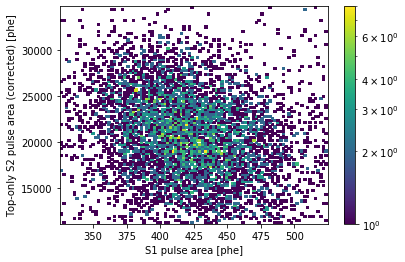

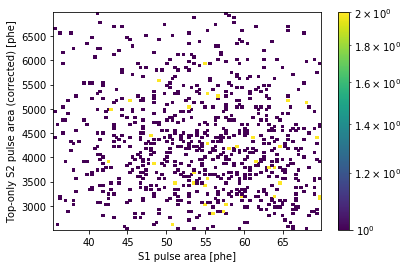

In [7]:
# -- Create a 2D histogram of S1 size vs S2 size
plt.figure()
h, xedges, yedges, img = plt.hist2d(filedata.S1_vals[Kshell_cut_indexer],filedata.TS2c_vals[Kshell_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area (corrected) [phe]")
plt.colorbar()

# -- Create a 2D histogram of S1 size vs Top-S2 size
plt.figure()
h, xedges, yedges, img = plt.hist2d(filedata.S1_vals[Lshell_cut_indexer],filedata.TS2c_vals[Lshell_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area (corrected) [phe]")
plt.colorbar()

In [8]:
## Define a 2D Gaussian for fitting
def Gauss2D(x, a, mu_x, mu_y, sig_x, sig_y, rho):
    r1  = (x[0]-mu_x)/sig_x
    r2  = (x[1]-mu_y)/sig_y
    ans = a * np.exp((-0.5 / (1-rho*rho))*(r1*r1+r2*r2-2*rho*r1*r2))
    return ans.ravel()   ## ravel is making the output of this a single dimension (for fitting)

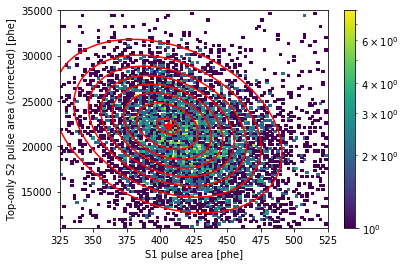

In [9]:
from scipy.optimize import curve_fit
## Figure 0 ------------------
## Do fit to K-shell----------
bin_num = 100

# -- Create a 2D histogram of S1 size vs S2 size
plt.figure()
ax = plt.gca()
hist, xedges, yedges, img = plt.hist2d(filedata.S1_vals[Kshell_cut_indexer],
                                       filedata.TS2c_vals[Kshell_cut_indexer], 
                                       bins=bin_num, 
                                       norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area (corrected) [phe]")
plt.colorbar()

# Create mesh grid ----------
x_bins = np.linspace(Kshell_s1_cut_lims[0]  , Kshell_s1_cut_lims[1] , num=bin_num)
y_bins = np.linspace(Kshell_ts2_cut_lims[0] , Kshell_ts2_cut_lims[1], num=bin_num)
x , y = np.meshgrid(xedges[:-1] , yedges[:-1])

# Fit 2D gaussian -----------
initial_guess = (10. , 425., 20.0e3, 15.0, 1.0e3, -0.5)
popt, pcov = curve_fit(Gauss2D, (x, y), hist.ravel(), p0=initial_guess)
perr = np.sqrt(np.diag(pcov)) ## This ignores any correlated errors

## Plot contour of fit -------
data_fitted = Gauss2D((x, y), *popt)

# - Plot Xe127 fit contour [DATA-Py fit]
ax.contour(x, y, data_fitted.reshape(bin_num, bin_num), 8, colors='r')

# - Plot center of Xe127 fit contour [DATA-Py fit]
plt.errorbar( popt[1] , popt[2] , 
    xerr=popt[3]/np.sqrt(np.sum(hist)) , 
    yerr=popt[4]/np.sqrt(np.sum(hist)), 
    c='r', fmt='*', markersize=10,
    label="K-shell Fit centroid")

plt.xlim([x_bins[0] , x_bins[len(x_bins)-1]])
plt.ylim([y_bins[0] , y_bins[len(y_bins)-1]])
##----------------------------

## Extract fit parameters
K_mean_S1     = popt[1]
K_mean_S1_uc  = perr[1]
K_mean_TS2    = popt[2]
K_mean_TS2_uc = perr[2]

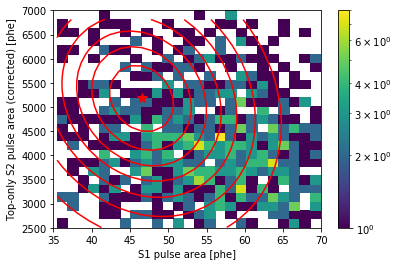

In [10]:
## Do fit to L-shell----------
bin_num = 25

# -- Create a 2D histogram of S1 size vs S2 size
plt.figure()
ax = plt.gca()
hist, xedges, yedges, img = plt.hist2d(filedata.S1_vals[Lshell_cut_indexer],
                                       filedata.TS2c_vals[Lshell_cut_indexer], 
                                       bins=bin_num, 
                                       norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area (corrected) [phe]")
plt.colorbar()

# Create mesh grid ----------
x_bins = np.linspace(Lshell_s1_cut_lims[0]  , Lshell_s1_cut_lims[1] , num=bin_num)
y_bins = np.linspace(Lshell_ts2_cut_lims[0] , Lshell_ts2_cut_lims[1], num=bin_num)
x , y = np.meshgrid(xedges[:-1] , yedges[:-1])

# Fit 2D gaussian -----------
initial_guess = (5. , 55., 4.0e3, 8.0, 1.5e3, -0.5)
popt, pcov = curve_fit(Gauss2D, (x, y), hist.ravel(), p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

## Plot contour of fit -------
data_fitted = Gauss2D((x, y), *popt)

# - Plot Xe127 fit contour [DATA-Py fit]
ax.contour(x, y, data_fitted.reshape(bin_num, bin_num), 8, colors='r')

# - Plot center of Xe127 fit contour [DATA-Py fit]
plt.errorbar( popt[1] , popt[2] , 
    xerr=popt[3]/np.sqrt(np.sum(hist)) , 
    yerr=popt[4]/np.sqrt(np.sum(hist)), 
    c='r', fmt='*', markersize=10,
    label="L-shell Fit centroid")

plt.xlim([x_bins[0] , x_bins[len(x_bins)-1]])
plt.ylim([y_bins[0] , y_bins[len(y_bins)-1]])
##----------------------------

L_mean_S1     = popt[1]
L_mean_S1_uc  = perr[1]
L_mean_TS2    = popt[2]
L_mean_TS2_uc = perr[2]

Text(0, 0.5, '(S2/E) [phe/keV]')

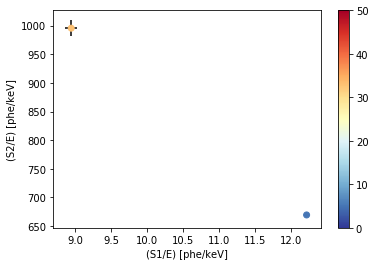

In [11]:
## Create the Doke Plot

# x-axis is S1 size over energy of peak
# y-axis is S2 size over energy of peak
# We have one point for K shell and one for L shell
# Don't forget to propagate uncertainties!

x_K    = K_mean_S1     / Kshell_energy
x_K_uc = K_mean_S1_uc  / Kshell_energy

y_K    = K_mean_TS2    / Kshell_energy
y_K_uc = K_mean_TS2_uc / Kshell_energy

x_L    = L_mean_S1     / Lshell_energy
x_L_uc = L_mean_S1_uc  / Lshell_energy

y_L    = L_mean_TS2    / Lshell_energy
y_L_uc = L_mean_TS2_uc / Lshell_energy

plt.figure()
plt.errorbar(x = [x_L, x_K],
             y = [y_L, y_K],
             xerr  = [x_L_uc, x_K_uc],
             yerr  = [y_L_uc, y_K_uc],
             color = "k", linestyle="None", zorder=0)
colormap = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter([x_L, x_K], [y_L, y_K], 
                 c=[Kshell_energy, Lshell_energy], 
                 vmin=(0.0), 
                 vmax=(50.0), 
                 cmap=colormap, zorder=1)
plt.colorbar(sc)
plt.xlabel("(S1/E) [phe/keV]")
plt.ylabel("(S2/E) [phe/keV]")

# Assignment
The following exercises will take you through performing the energy calibration.

## Problem 1.
Calculate the slope and intercept of the line specified by the two points in the Doke plot. What are their units?

In [17]:
## Put your answer to Problem 1 here
slope = (y_K - y_L) / (x_K - x_L)  ## dimensionless
incpt = y_K - (slope*x_K)          ## phe / keV
print(slope, incpt)

-99.74970407517306 1887.7223307151407


## Problem 2.
Use algebra to rearrange the combined energy equation to the form $y=mx+b$. Looking at the Doke plot, we know $y=S2/E$ and $x=S1/E$. What are the slope and intercept in terms of $g_1, g_2,$ and $W$?

### Put your answer for Problem 2 here
First divide both sides of the combined energy equation by the product $EW$:
$$ \frac{1}{W} = \frac{S1}{E} \frac{1}{g_1} + \frac{S2}{E} \frac{1}{g_2} $$
Next, multiply both sides by $g_2$:
$$ \frac{g_2}{W} = \frac{S1}{E} \frac{g_2}{g_1} + \frac{S2}{E} $$
Then simply rearrange:
$$ \frac{S2}{E} = - \left( \frac{g_2}{g_1} \right) \frac{S1}{E} + \frac{g_2}{W} $$

## Problem 3.
Rearrange your expressions from above, such that you have expressions for $g_1$ and $g_2$ in terms of $b,m,$ and $W$. What are the values and units of $g_1, g_2$ from our Doke plot?

### Put your answer for Problem 3 here
From the above, we see $m = -g_2 / g_1$ and $b=g_2/W$. Simple inversion yields
$$ g_2 = W b $$
and
$$ g_1 = - g_2 / m = - W b / m $$

In [21]:
W_val_keV = 13.7e-3

def calculate_g2(_slope, _incpt):
    return W_val_keV * _incpt

def calculate_g1(_slope, _incpt):
    return -1. * calculate_g2(_slope, _incpt) / _slope

g1_val = calculate_g1(slope, incpt)
g2_val = calculate_g2(slope, incpt)
print("g1:", g1_val, "phe / photon")
print("g2:", g2_val, "phe / electron")

g1: 0.2592668937775248 phe / photon
g2: 25.861795930797427 phe / electron


## Problem 4.
Calculate the reconstructed energy for each point in the dataset. Save it to the class structure. Make a 1D plot of reconstructed energy for all events passing a drift time cut.

Text(0, 0.5, 'Counts per 0.1 keV')

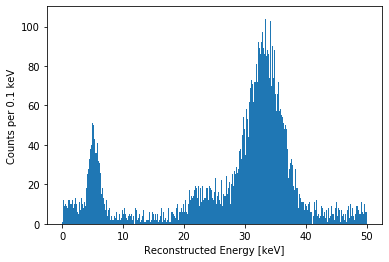

In [25]:
## Put your answer for Problem 4 here
def Recon_E_keV(s1_vals, s2_vals):
    n_gamma = s1_vals / g1_val
    n_elec  = s2_vals / g2_val
    return W_val_keV * (n_gamma + n_elec)

filedata.recon_E = Recon_E_keV(filedata.S1_vals , filedata.TS2c_vals)

E_bins = np.linspace(start=0.0 , stop=50.0 , num=500)
# -- Then create a 1D histogram
plt.figure()
n_cts, bins, patches = plt.hist(filedata.recon_E[dt_cut_indexer], bins=E_bins)
plt.xlabel("Reconstructed Energy [keV]")
plt.ylabel("Counts per 0.1 keV")